## Package

In [3]:
!pip install fastai -Uqq

     |████████████████████████████████| 213 kB 5.1 MB/s 
     |████████████████████████████████| 61 kB 9.1 MB/s 


In [4]:
from fastai.vision.all import *

## CNN Interpretation with CAM

### Cam and Hooks

It uses the output of the last convolutional layer (just before the average pooling layer) together with the predictions to give us a heatmap visualization of why the model made its decision

In [5]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.134517,0.015159,0.006766,00:52


epoch,train_loss,valid_loss,error_rate,time
0,0.065453,0.014981,0.006089,00:53


In [6]:
x, y = dls.one_batch()
xi = x[0][None]

In [20]:
class Hook():
  def hook_func(self, m, i, o):
    self.stored = o.detach().clone()

In [21]:
hook_output = Hook()

hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [22]:
with torch.no_grad():
  output = learn.model.eval()(xi)

In [23]:
act = hook_output.stored[0]

In [24]:
F.softmax(output, dim = -1)

TensorBase([[9.9984e-01, 1.6146e-04]], device='cuda:0')

In [25]:
y[0], dls.vocab

(TensorCategory(0, device='cuda:0'), [False, True])

In [26]:
x.shape

torch.Size([64, 3, 224, 224])

In [27]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

In [28]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])

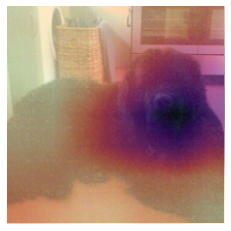

In [29]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [30]:
hook.remove()

In [31]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [32]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

### Gradient CAM

In [33]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [37]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,1].backward()
    grad = hookg.stored

w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


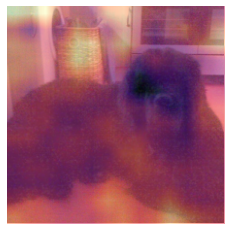

In [38]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');